Epoch 1/100
1030/1030 [==============================] - 80s 76ms/step - loss: 8.1757 - accuracy: 0.5271 - val_loss: 5.9409 - val_accuracy: 0.5309
Epoch 2/100
1030/1030 [==============================] - 70s 67ms/step - loss: 4.8368 - accuracy: 0.6610 - val_loss: 4.0132 - val_accuracy: 0.8298
Epoch 3/100
1030/1030 [==============================] - 73s 71ms/step - loss: 3.4915 - accuracy: 0.8171 - val_loss: 3.0429 - val_accuracy: 0.8646
Epoch 4/100
1030/1030 [==============================] - 86s 84ms/step - loss: 2.6806 - accuracy: 0.8696 - val_loss: 2.3494 - val_accuracy: 0.8807
Epoch 5/100
1030/1030 [==============================] - 68s 66ms/step - loss: 2.0603 - accuracy: 0.9014 - val_loss: 1.7909 - val_accuracy: 0.9007
Epoch 6/100
1030/1030 [==============================] - 71s 69ms/step - loss: 1.5451 - accuracy: 0.9246 - val_loss: 1.3063 - val_accuracy: 0.9162
Epoch 7/100
1030/1030 [==============================] - 72s 70ms/step - loss: 1.1285 - accuracy: 0.9389 - val_loss: 0

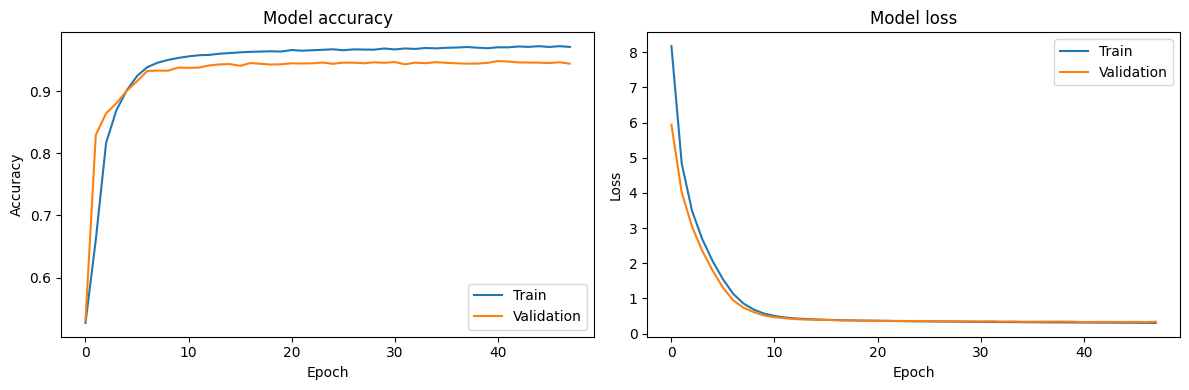

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler

# Load the dataset
df = pd.read_csv('/content/cleaned_dataset_combined (4).csv')

# Define feature and target variables
X = df['tweet']
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RandomOverSampler to oversample the minority class in the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert the resampled data back to their original shape
X_train_resampled = X_train_resampled.flatten()

# Use TfidfVectorizer for the 'tweet' column
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_resampled)
X_test_tfidf = tfidf.transform(X_test)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_resampled)
y_test_one_hot = to_categorical(y_test)

# Build the model
model = Sequential()
model.add(Dense(256, input_dim=X_train_tfidf.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(df['class'].unique()), activation='softmax'))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_tfidf.toarray(), y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_tfidf.toarray(), y_test_one_hot), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_one_hot)
print(f'Test set accuracy: {accuracy:.2f}')

# Generate classification report
y_pred = model.predict(X_test_tfidf.toarray())
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test_one_hot.argmax(axis=1)

print(classification_report(y_test_classes, y_pred_classes))

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()
